# FCN Semantic Segmentation Demo

by Jason Fan and Jay Destories

Some setup...

In [11]:
import numpy as np
from PIL import Image
from IPython import display
import caffe
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
class_map = {
    0: 'Background',
    1: 'Airplane',
    2: 'Bicycle',
    3: 'Bird',
    4: 'Boat',
    5: 'Bottle',
    6: 'Bus',
    7: 'Car',
    8: 'Cat',
    9: 'Chair',
    10: 'Cow',
    11: 'Dining table',
    12: 'Dog',
    13: 'Horse',
    14: 'Motorbike',
    15: 'People',
    16: 'Potted plant',
    17: 'Sheep',
    18: 'Sofa',
    19: 'Train',
    20: 'TV/Monitors'
}

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')
    
def segment_image(imagepath, net):
    image = Image.open(imagepath)
    image_array = np.array(image, dtype=np.float32) 
    # preprocessing
    #rgb -> bgr
    pp_image = image_array[:,:,::-1]
    #subtract training mean
    pp_image -= np.array((104.00698793,116.66876762,122.67891434))[None,None,:]
    imshow_noax(pp_image)
    #transpose to expected orientation
    pp_image = pp_image.transpose((2,0,1))
    net.blobs['data'].reshape(1, *pp_image.shape)
    net.blobs['data'].data[...] = pp_image
    net.forward()
    out = net.blobs['score'].data[0].argmax(axis=0)
    classes = np.unique(out)
    for c in classes:
        num_pixels = (out == c).sum()
        print "{}: {}".format(class_map[c], num_pixels)
    return out

def showimage(imagepath):
    image = Image.open(imagepath)
    image_array = np.array(image, dtype=np.float32) 
    imshow_noax(image_array)
    return

def segment_and_display(path, net):
    imshow_noax(segment_image(path, net))
    


## Instantiate Two FCNs...

Using caffe, we grab prototexts and weights to instantiate our the FCN8s and FCN16s

In [42]:
net = caffe.Net('./voc-fcn8s/deploy.prototxt',
                'voc-fcn8s/fcn8s-heavy-pascal.caffemodel',
                caffe.TEST)

net16 = caffe.Net('./voc-fcn16s/deploy.prototxt',
                'voc-fcn16s/fcn16s-heavy-pascal.caffemodel',
                caffe.TEST)

## Two fun examples!

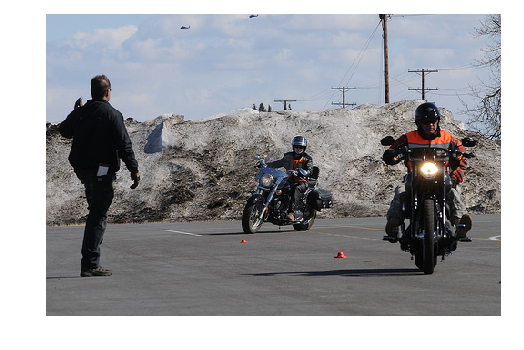

In [36]:
showimage('data/bikes.jpg')

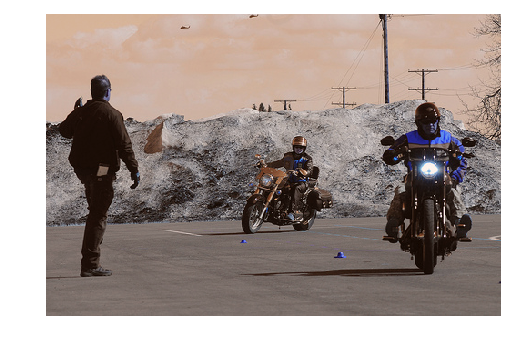

In [15]:
# preprocessing

#rgb -> bgr
pp_image = image_array[:,:,::-1]
#subtract training mean
pp_image -= np.array((104.00698793,116.66876762,122.67891434))[None,None,:]
imshow_noax(pp_image)
#transpose to expected orientation
pp_image = pp_image.transpose((2,0,1))

Background: 139257
Motorbike: 16436
People: 10307


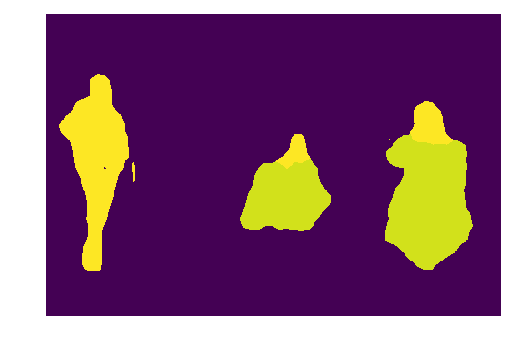

In [40]:
segment_and_display('data/bikes.jpg', net)

Background: 139462
Motorbike: 16248
People: 10290


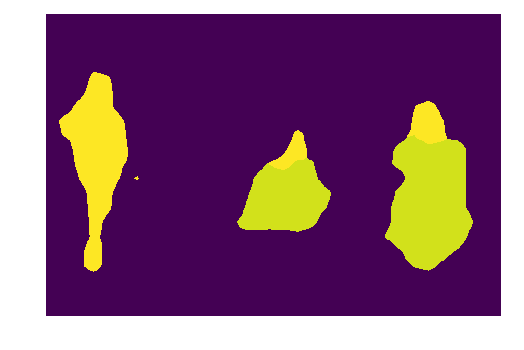

In [43]:
segment_and_display('data/bikes.jpg', net16)

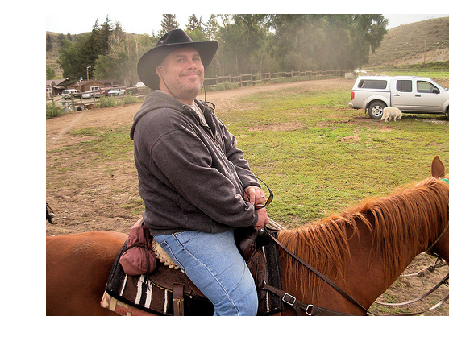

In [44]:
showimage("data/complex.jpg")

Background: 104628
Car: 5918
Horse: 34459
People: 42495


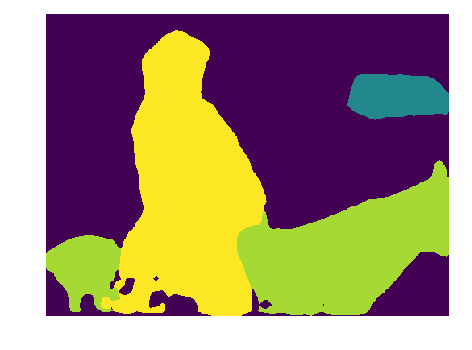

In [45]:
segment_and_display('data/complex.jpg', net)

Background: 104230
Car: 5850
Horse: 34405
People: 43015


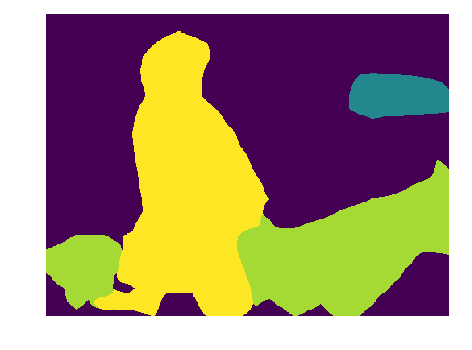

In [46]:
segment_and_display('data/complex.jpg', net16)

## A little bit of analysis

Notice how the FCN is able to capture high level, local, features of the horse and be able to segment it without seeing the whole horse.

Notice that the FCN fails to segment the dog, coarse grained nature of upsampling means that the dog features are lost
during implicit downsampling from convolutional layers

# Things that the FCNs are not very good at:

The FCN can recognize what class patches of the image are, but it cannot semantically segement or identify multiple instances of the same object. So when objects of the same class oclude eachother in the same scene, the FCN produces interesting but oftentimes not very informative results

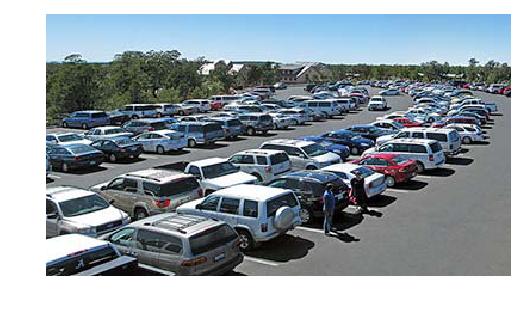

In [47]:
showimage("data/parkinglot.jpg")

Background: 67767
Car: 18033


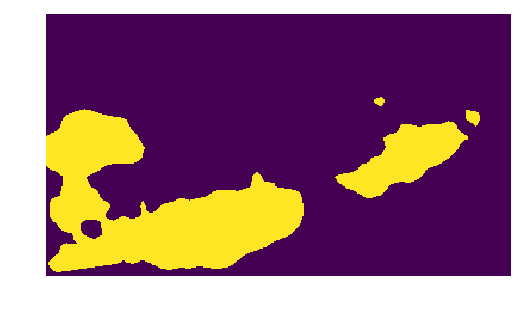

In [49]:
segment_and_display("data/parkinglot.jpg", net)

Background: 68619
Car: 17181


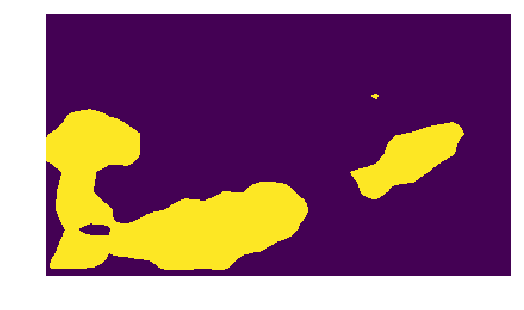

In [50]:
segment_and_display("data/parkinglot.jpg", net16)

The FCN is really good at capturing features and segmenting patches of the image in a local sense, it does not "do the right thing" when visual features in a scene interact with eachother. For example, it is really bad at producing semantically sensible results for reflective objects.

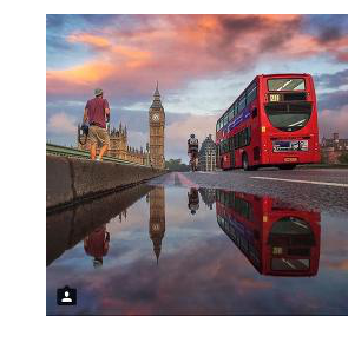

In [51]:
showimage("data/reflect.jpg")

Background: 57205
Bus: 4912
Car: 3419


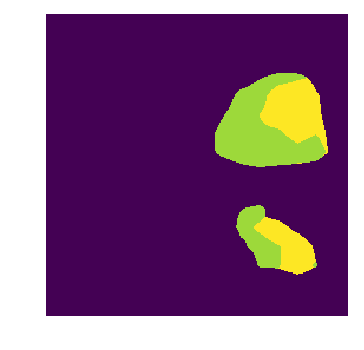

In [54]:
segment_and_display("data/reflect.jpg", net16)

# Notes and Acknowledgements

## Exploring more images

We found it useful to explore the MS COCO dataset to find images to segment.

See: http://mscoco.org/explore/
        
You can explore the dataset and find images with instances of objects you specify!

## FCN source code

You can find the FCN work done by the Berkeley Vision group here.

If you want to test FCNs that are not FCN8s, you will have to make your own deploy.prototxt for each network by
changing the bottom data layer and removing the dropout layers from the train.prototxt.

https://github.com/shelhamer/fcn.berkeleyvision.org


## Pascal Voc

You can find the Pascal Voc Challenge here.

http://host.robots.ox.ac.uk/pascal/VOC/
